# 12 — Evaluation, Inference, and Practical Pitfalls

Purpose: compute confusion matrix and derived metrics (accuracy, precision, recall, F1), tune classification thresholds, build a simple inference pipeline (preprocessing + model + postprocessing), and discuss common real-world failure modes.

## Learning goals
- Compute confusion matrix for binary classification.
- Compute accuracy, precision, recall, F1.
- Tune probability thresholds and visualize trade-offs.
- Structure an inference pipeline: preprocess (train-fit params), predict, postprocess.
- Recognize practical pitfalls: unclear objectives, leakage, drift, threshold changes, monitoring needs.

## Prerequisites
- Notebook 04 (binary classification outputs).
- Notebook 08–09 (train-only preprocessing).
- Basic NumPy.

## Key ideas
- Accuracy is not enough when classes are imbalanced or costs differ.
- Threshold is a product decision: it sets precision/recall trade-offs.
- Inference is a pipeline, not just `model(x)`.
- Post-training changes (threshold updates, monitoring) are part of the system.

## Minimal theory
- Confusion matrix (binary): TP, FP, TN, FN.
- Precision = TP/(TP+FP), Recall = TP/(TP+FN), F1 = 2PR/(P+R).
- Threshold tuning changes FP/FN balance.
- Distribution shift (drift) breaks static assumptions; monitor input and output statistics.

Final train loss: 0.2557480095969872


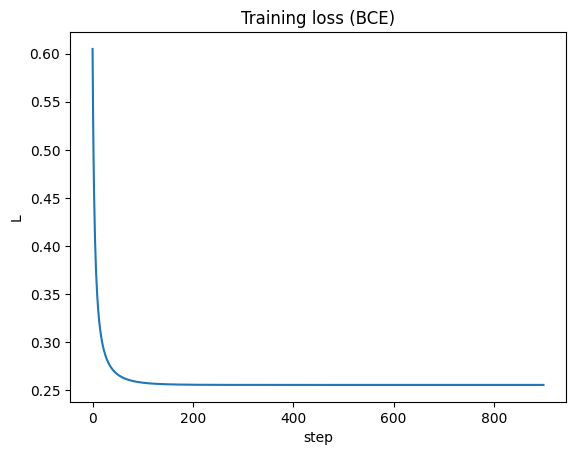

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_from_logits(z, y):
    t = np.maximum(z, 0) - z*y + np.log1p(np.exp(-np.abs(z)))
    return float(np.mean(t))

def standardize_fit(x):
    mu = x.mean(axis=0, keepdims=True)
    sigma = x.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(x, mu, sigma):
    return (x - mu) / sigma

def split_train_test(x, y, test_ratio=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    N = x.shape[0]
    idx = rng.permutation(N)
    n_te = int(N*test_ratio)
    te = idx[:n_te]
    tr = idx[n_te:]
    return x[tr], y[tr], x[te], y[te]

def train_logreg(x_tr, y_tr, lr=0.6, steps=800):
    N, D = x_tr.shape
    W = rng.normal(0, 0.1, size=(D,1))
    b = np.zeros((1,1))
    losses = []
    for _ in range(steps):
        z = x_tr @ W + b
        a = sigmoid(z)
        dz = (a - y_tr)/N
        dW = x_tr.T @ dz
        db = np.sum(dz, axis=0, keepdims=True)
        W -= lr*dW
        b -= lr*db
        losses.append(bce_from_logits(x_tr @ W + b, y_tr))
    return W, b, np.array(losses)

def confusion_binary(y_true, y_pred):
    # y_*: (N,1) in {0,1}
    yt = y_true.astype(int).reshape(-1)
    yp = y_pred.astype(int).reshape(-1)
    TP = int(np.sum((yt==1) & (yp==1)))
    FP = int(np.sum((yt==0) & (yp==1)))
    TN = int(np.sum((yt==0) & (yp==0)))
    FN = int(np.sum((yt==1) & (yp==0)))
    return TP, FP, TN, FN

def metrics_from_conf(TP, FP, TN, FN):
    acc = (TP + TN) / (TP + FP + TN + FN + 1e-12)
    prec = TP / (TP + FP + 1e-12)
    rec = TP / (TP + FN + 1e-12)
    f1 = 2*prec*rec / (prec + rec + 1e-12)
    return float(acc), float(prec), float(rec), float(f1)

# Synthetic imbalanced dataset
N = 1200
neg = int(N*0.85)
pos = N - neg
x0 = rng.normal(loc=(0.0, 0.0), scale=1.0, size=(neg,2))
x1 = rng.normal(loc=(1.3, 1.0), scale=0.7, size=(pos,2))
x = np.vstack([x0, x1])
y = np.vstack([np.zeros((neg,1)), np.ones((pos,1))])
idx = rng.permutation(N)
x, y = x[idx], y[idx]

x_tr, y_tr, x_te, y_te = split_train_test(x, y, test_ratio=0.25, rng=rng)
mu, sig = standardize_fit(x_tr)
x_tr_s = standardize_apply(x_tr, mu, sig)
x_te_s = standardize_apply(x_te, mu, sig)

W, b, losses = train_logreg(x_tr_s, y_tr, lr=0.6, steps=900)
print('Final train loss:', losses[-1])

plt.figure()
plt.plot(losses)
plt.title('Training loss (BCE)')
plt.xlabel('step')
plt.ylabel('L')
plt.show()

## Step-by-step experiments
1. Compute probabilities on test and evaluate at threshold 0.5.
2. Sweep thresholds and compute precision/recall/F1.
3. Pick a threshold based on an explicit goal (e.g., maximize F1 or enforce recall).
4. Build a minimal inference pipeline function that uses stored preprocessing params.
5. Demonstrate a drift scenario by shifting test distribution and observing metric changes.

Threshold: 0.5
Confusion (TP,FP,TN,FN): 18 5 248 29
acc, precision, recall, f1: 0.8866666666666636 0.78260869565214 0.38297872340424716 0.5142857142852584
Best threshold by F1: 0.2330508474576271 F1: 0.755102040815812


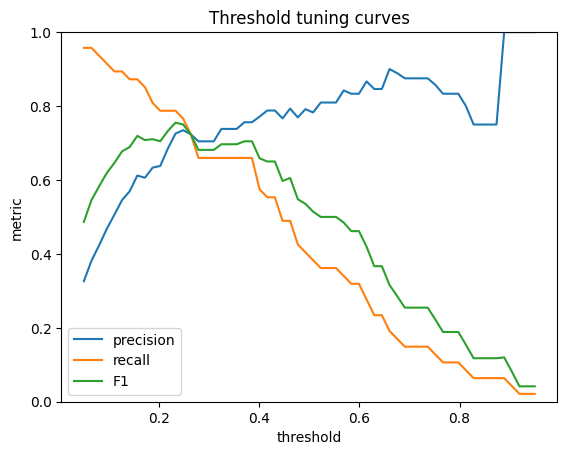

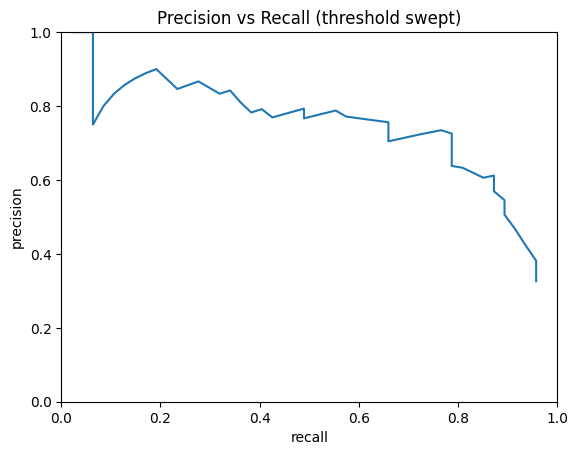

In [2]:
z_te = x_te_s @ W + b
p_te = sigmoid(z_te)

thr = 0.5
yhat = (p_te >= thr).astype(float)
TP, FP, TN, FN = confusion_binary(y_te, yhat)
acc, prec, rec, f1 = metrics_from_conf(TP, FP, TN, FN)
print('Threshold:', thr)
print('Confusion (TP,FP,TN,FN):', TP, FP, TN, FN)
print('acc, precision, recall, f1:', acc, prec, rec, f1)

# Threshold sweep
ths = np.linspace(0.05, 0.95, 60)
prec_list, rec_list, f1_list = [], [], []
for t in ths:
    yh = (p_te >= t).astype(float)
    TP, FP, TN, FN = confusion_binary(y_te, yh)
    _, pr, rc, f1v = metrics_from_conf(TP, FP, TN, FN)
    prec_list.append(pr)
    rec_list.append(rc)
    f1_list.append(f1v)

prec_list = np.array(prec_list)
rec_list = np.array(rec_list)
f1_list = np.array(f1_list)

best_idx = int(np.argmax(f1_list))
best_thr = float(ths[best_idx])
print('Best threshold by F1:', best_thr, 'F1:', float(f1_list[best_idx]))

# Plot 1: precision/recall vs threshold
plt.figure()
plt.plot(ths, prec_list, label='precision')
plt.plot(ths, rec_list, label='recall')
plt.plot(ths, f1_list, label='F1')
plt.title('Threshold tuning curves')
plt.xlabel('threshold')
plt.ylabel('metric')
plt.ylim(0,1)
plt.legend()
plt.show()

# Plot 2: PR-like curve (precision vs recall)
plt.figure()
plt.plot(rec_list, prec_list)
plt.title('Precision vs Recall (threshold swept)')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

Using best_thr: 0.2330508474576271
acc, precision, recall, f1: 0.9199999999999968 0.7254901960784171 0.7872340425531748 0.755102040815812
DRIFT metrics (same threshold): 0.8399999999999971 0.49425287356321274 0.914893617021257 0.6417910447756544


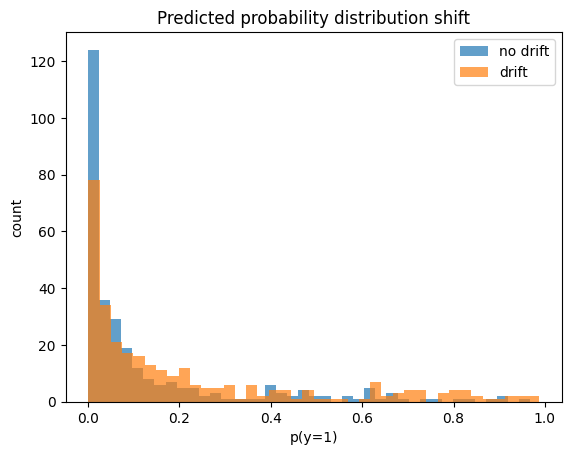

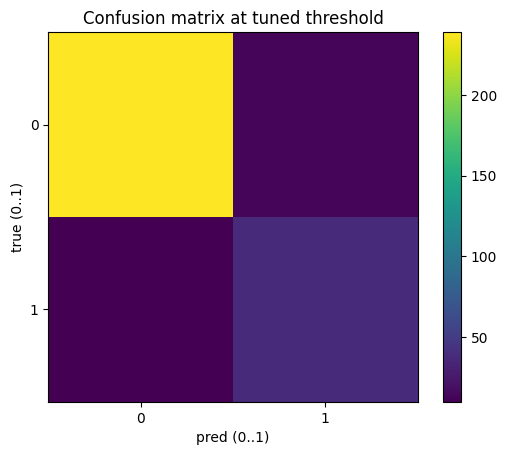

In [3]:
# Inference pipeline (preprocess -> model -> postprocess)
def inference_pipeline(x_raw, mu, sig, W, b, threshold=0.5):
    x_s = standardize_apply(x_raw, mu, sig)
    z = x_s @ W + b
    p = sigmoid(z)
    yhat = (p >= threshold).astype(int)
    return p, yhat

p1, yhat1 = inference_pipeline(x_te, mu, sig, W, b, threshold=best_thr)
TP, FP, TN, FN = confusion_binary(y_te, yhat1)
acc, prec, rec, f1 = metrics_from_conf(TP, FP, TN, FN)
print('Using best_thr:', best_thr)
print('acc, precision, recall, f1:', acc, prec, rec, f1)

# Drift demo: shift test inputs (simulate deployment change)
x_te_drift = x_te + np.array([1.2, -0.8])
p2, yhat2 = inference_pipeline(x_te_drift, mu, sig, W, b, threshold=best_thr)
TP2, FP2, TN2, FN2 = confusion_binary(y_te, yhat2)
acc2, prec2, rec2, f12 = metrics_from_conf(TP2, FP2, TN2, FN2)
print('DRIFT metrics (same threshold):', acc2, prec2, rec2, f12)

# Plot 1: probability histograms (no drift vs drift)
plt.figure()
plt.hist(p1[:,0], bins=40, alpha=0.7, label='no drift')
plt.hist(p2[:,0], bins=40, alpha=0.7, label='drift')
plt.title('Predicted probability distribution shift')
plt.xlabel('p(y=1)')
plt.ylabel('count')
plt.legend()
plt.show()

# Plot 2: confusion matrix visualization (as a 2x2 image)
cm = np.array([[TN, FP],[FN, TP]])
plt.figure()
plt.imshow(cm)
plt.title('Confusion matrix at tuned threshold')
plt.xlabel('pred (0..1)')
plt.ylabel('true (0..1)')
plt.colorbar()
plt.xticks([0,1], ['0','1'])
plt.yticks([0,1], ['0','1'])
plt.show()

## Reflection questions
1. Why is accuracy a misleading metric under class imbalance?
2. How would you choose a threshold if false negatives are very costly?
3. What exactly must be stored to reproduce inference (besides weights)?
4. Which monitoring signals would you track in production for drift?
5. What is a safe process for updating thresholds after deployment?

## Optional extensions
1. Add a cost function (cost_FP, cost_FN) and choose threshold to minimize expected cost.
2. Implement a simple calibration check: bucket probabilities and compare empirical rates.
3. Build a “shadow evaluation” loop to compare current model vs new model on the same stream (simulated).

## Summary
- Evaluation requires more than accuracy: precision/recall/F1 matter.
- Threshold is a product and risk decision.
- Inference is a pipeline: preprocess + model + postprocess.
- Drift can break performance without code changes.
- Production readiness includes monitoring and controlled updates.